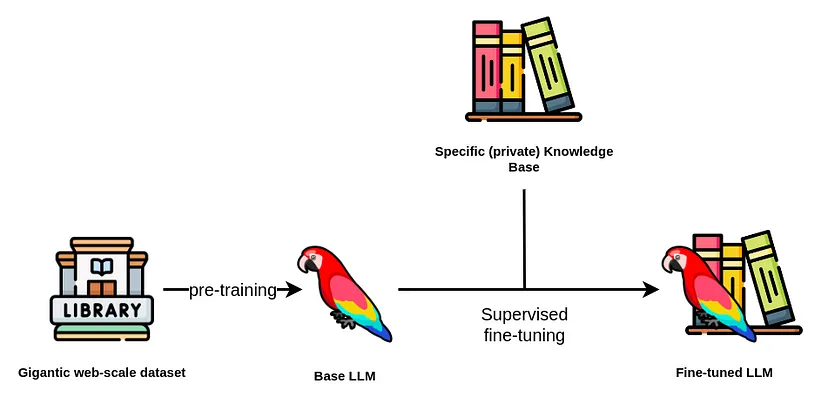

In [1]:
!pip install -q -U transformers datasets accelerate peft trl bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 9.2 MB/s eta 0:00:00


In [2]:
from google.colab import userdata

# Defined in the secrets tab in Google Colab
hf_token = userdata.get('huggingface')

In [3]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training, get_peft_model
from trl import SFTTrainer  # Supervised fine-tuning Trainer optimizes model on labeled data efficiently.

In [4]:
# Model
model_name = "meta-llama/Llama-2-7b-chat-hf"
new_model = "llama-2-7b-html"

# Dataset
train_dataset = load_dataset("Guna0pro/HTML-Data", split="train")
valid_dataset = load_dataset("Guna0pro/HTML-Data", split="test")

Generating train split:   0%|          | 0/445 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/95 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/96 [00:00<?, ? examples/s]

**Good data forms the foundation for creating a better model; it's akin to having a solid base for building something great.** Therefore, I created a dataset for fine-tuning myself. Find the source code [link] here.

In [5]:
train = train_dataset.to_pandas()
print("total no of rows in training", len(train))

test = valid_dataset.to_pandas()
print("total no of rows in training", len(test))

total no of rows in training 445
total no of rows in training 95


In [6]:
print(train['text'][0])

[INST] <> Create a simple webpage to welcome visitors with a centered heading "Welcome". <> [/INST] <!DOCTYPE html>
<html>
<head>
 <title>Welcome</title>
 <style>
  h1 {
  text-align: center;
  }
 </style>
</head>
<body>
<h1>Welcome</h1>
</body>
</html> 


In [7]:
bnb_config = BitsAndBytesConfig(
      load_in_4bit = True,
      bnb_4bit_quant_type='nf4',
      bnb_4bit_compute_dtype=torch.float16
  )

In [8]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [9]:
model = AutoModelForCausalLM.from_pretrained(model_name,
                             quantization_config = bnb_config,
                             device_map = DEVICE,
                             token = hf_token)

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

In [10]:
# when the cache is enabled, the model’s forward pass behavior can be less variable, as it reuses cached results.
model.config.use_cache = False

In [11]:
tokenizer = AutoTokenizer.from_pretrained(model_name, token = hf_token)
tokenizer.pad_token = tokenizer.eos_token    # # Set the padding token for the tokenizer to be the same as the end-of-sequence (eos) token.
tokenizer.padding_side = 'right'             # Set the padding side to 'right', indicating that padding will be added to the right side of the input sequences.

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [12]:
# Run text generation pipeline with our model

prompt = 'Write an HTML template to display a greeting message. The message should include the name of the user who visits the website.'


pipe = pipeline(task = 'text-generation', model = model, tokenizer = tokenizer, max_length = 200)


result = pipe(f"[INST] {prompt} [/INST]")
print(result[0]['generated_text'])


# I used the prompt template suggested by the officials. Find more details at https://gpus.llm-utils.org/llama-2-prompt-template/

[INST] Write an HTML template to display a greeting message. The message should include the name of the user who visits the website. [/INST]  Sure! Here is an HTML template you can use to display a greeting message that includes the name of the user who visits the website:
```
<!DOCTYPE html>
<html>
<head>
  <title>Welcome to My Website</title>
</head>
<body>
  <h1>Welcome, {{ user_name }}!</h1>
  <p>You are visiting my website at {{ current_time }}.</p>
</body>
</html>
```
In this template, we use the `{{ }}` syntax to insert the name of the user who visits the website into the greeting message. The `user_name` variable will be filled in with the actual name of the user when the


In [13]:
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

# adjusts the model architecture or training process to facilitate knowledge distillation specifically using the K-BiT approach (Knowledge-Bridge in Transformers) method

In [14]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRM

# **Explanation of 32 Layers**

* A stack of 32 decoder layers. Each layer is an instance of LlamaDecoderLayer.
* **self_attn:** Self-attention mechanism within each decoder layer.
  * q_proj, k_proj, v_proj, o_proj: Linear projections for queries, keys, values, and the output of the attention mechanism, respectively.

  * rotary_emb: LlamaRotaryEmbedding, potentially for introducing positional information using rotary embeddings.

* **mlp:** Multi-Layer Perceptron (MLP) component within each decoder layer.
  * gate_proj, up_proj, down_proj: Linear projections for gating and MLP operations.
  * act_fn: Activation function, specifically the SiLU (Sigmoid-weighted Linear Unit) function.
* **input_layernorm, post_attention_layernorm:** RMS normalization layers applied before and after the attention mechanism, respectively.


**7B model have 32 layers, 13B model have 40 layers**

In [15]:
peft_config = LoraConfig(
    r = 64,     #LoRA attention dimension
    lora_alpha = 16,  # parameter for scaling
    target_modules = ['q_proj', 'k_proj', 'v_proj', 'o_proj'],   # target_modules is set using our helper functions - every layer identified by that function will be included in the PEFT update.
    bias = 'none',
    lora_dropout = 0.1,  # typical dropout rate for regularization
    task_type = 'CAUSAL_LM'
)

In [16]:
training_arguments = TrainingArguments(
    per_device_train_batch_size = 4,  # Batch size per GPU for training
    gradient_accumulation_steps = 2,  # Number of update steps to accumulate the gradients for
    optim = 'paged_adamw_32bit',      # Optimizer to use
    logging_steps = 5,                # Log every X updates steps
    learning_rate = 2e-4,
    fp16 = False,
    max_grad_norm = 0.3,              # Maximum gradient normal (gradient clipping)
    max_steps = -1,
    num_train_epochs = 1,             # Number of training epochs
    warmup_ratio = 0.03,
    group_by_length = True,           # Group sequences into batches with same length  Saves memory and speeds up training considerably
    output_dir = 'output_dir',
    report_to = 'tensorboard',
    lr_scheduler_type = 'constant',     # Learning rate schedule (constant a bit better than cosine)
    seed = 42  ##Same as we specified in data shuffling
)

model.config.use_cache = False

In [17]:
trainer = SFTTrainer(
    model=model,
    train_dataset = train_dataset,
    eval_dataset = valid_dataset,
    peft_config=peft_config,                # use our lora peft config
    dataset_text_field="text",              # parameter is used to indicate which field in the dataset contains the text data that serves as input to to model
    max_seq_length=None,                    # no max sequence length
    tokenizer=tokenizer,                    # use the llama tokenizer
    args=training_arguments,                # use the training arguments
    packing=False,                          # don't need packing
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:222: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/445 [00:00<?, ? examples/s]

Map:   0%|          | 0/95 [00:00<?, ? examples/s]

In [18]:
trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
5,0.952500
10,1.104800
15,1.087500
20,0.661800
25,0.749200
30,0.601600
35,0.567900
40,0.647700
45,0.484400
50,0.532900


TrainOutput(global_step=56, training_loss=0.7304595985582897, metrics={'train_runtime': 434.9884, 'train_samples_per_second': 1.023, 'train_steps_per_second': 0.129, 'total_flos': 4452914367651840.0, 'train_loss': 0.7304595985582897, 'epoch': 1.0})

Trained model for 56 steps, achieving a training loss of 0.73. Training runtime: 435 seconds, processing 1.02 samples/second.

In [19]:
trainer.model.save_pretrained(new_model)

In [20]:
# Delete model, pipeline, trainer; garbage collect to free resources.

del model
del pipe
del trainer
import gc
gc.collect()
gc.collect()

32303

In [21]:
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map={"": 0}, # Map the model to the first GPU (if available)
)

model = PeftModel.from_pretrained(base_model, new_model)

# This step is often done to remove unnecessary overhead from the base_model.
model = model.merge_and_unload()

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code = True)
tokenizer.pad_token = tokenizer.eos_token # Set the padding token to the end-of-sequence token and configure padding side.
tokenizer.padding_side = 'right'  # This is done to ensure consistent padding behavior.

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [22]:
model.push_to_hub(new_model, use_temp_dir=False, token=hf_token)
tokenizer.push_to_hub(new_model, use_temp_dir=False, token=hf_token)

model-00002-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/3.59G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Guna0pro/llama-2-7b-html/commit/a4668941be2b1c0213812227caea4cfda3305720', commit_message='Upload tokenizer', commit_description='', oid='a4668941be2b1c0213812227caea4cfda3305720', pr_url=None, pr_revision=None, pr_num=None)